In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Read the data
data = pd.read_csv('../.dataset/BTC-USD-3.2018-3.2024.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
1,2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2,2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
3,2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
4,2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904


In [10]:
# Set the date as the index
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904


In [11]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    df['MA200_low'] = df['Low'].rolling(window=200).min()
    df['MA14_low'] = df['Low'].rolling(window=14).min()
    df['MA200_high'] = df['High'].rolling(window=200).max()
    df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    # 
    return df

                  Close       MACD        RSI
Date                                         
2018-10-02  6556.100098 -10.684094  63.027742
2018-10-03  6502.589844 -16.371112  49.387182
2018-10-04  6576.689941 -14.729068  43.431147
2018-10-05  6622.479980  -9.621947  42.845692
2018-10-06  6588.310059  -8.236796  50.614096
                  Close  MACD_lag1   RSI_lag1
Date                                         
2018-10-03  6502.589844 -10.684094  63.027742
2018-10-04  6576.689941 -16.371112  49.387182
2018-10-05  6622.479980 -14.729068  43.431147
2018-10-06  6588.310059  -9.621947  42.845692
2018-10-07  6602.950195  -8.236796  50.614096


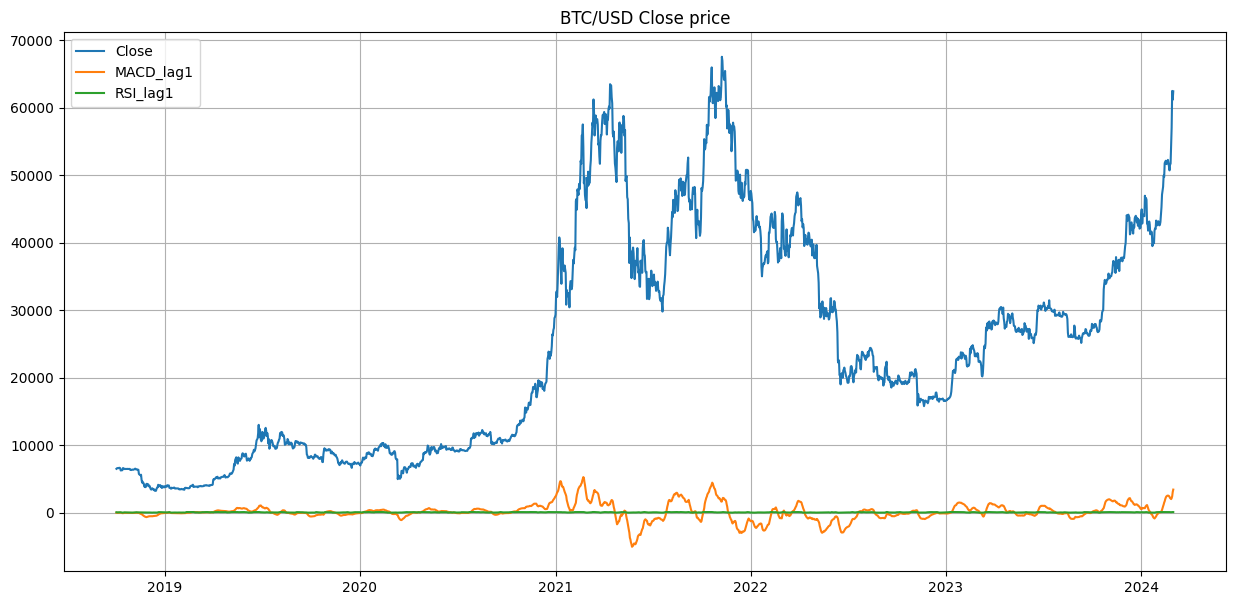

In [12]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            # 'Bollinger_Upper',
            # 'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            # 'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            # 'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]

# Create the dataset with features
df_features = createFeatures(data)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()

# Filter the data to the list of FEATURES
print(df_filtered.head().to_string())

# Create the lag of FEATURES (1 day before)
for feature in FEATURES:
   # drop the original feature except for the close price
    if feature != 'Close':
        df_filtered[feature + '_lag1'] = df_filtered[feature].shift(1)
        df_filtered.drop(feature, axis=1, inplace=True)
        
  
    

# Filter the data to the list of FEATURES
df_filtered = df_filtered.dropna()
print(df_filtered.head().to_string())

# Create the lineplot
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('BTC/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()


In [14]:
# Scale the data
df = df_filtered.copy()

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data = scaler.fit_transform(df)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_close = pd.DataFrame(df['Close'])
np_close = scaler_pred.fit_transform(df_close)

In [15]:
print(df_filtered.shape)

(1977, 3)


In [16]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Training, validation, test
train_size = int(len(np_data) * 0.70)
val_size = int(len(np_data) * 0.2)
test_size = len(np_data) - train_size - val_size
train_data, val_data, test_data = np_data[0:train_size], np_data[train_size:train_size+val_size], np_data[train_size+val_size:len(np_data)]

In [17]:
print(train_data.shape, val_data.shape, test_data.shape)

(1383, 3) (395, 3) (199, 3)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(data, time_steps):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(data_len - time_steps):
        row = [r for r in data[i: i + time_steps]]
        x.append(row)
        label = data[i + time_steps][0]
        y.append(label)
    return np.array(x), np.array(y)
    

# Generate training data and test data
X_train, y_train = partition_dataset(train_data, sequence_length)
X_val, y_val = partition_dataset(val_data, sequence_length)
X_test, y_test = partition_dataset(test_data, sequence_length)

In [19]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1376, 7, 3) (1376,)
(388, 7, 3) (388,)
(192, 7, 3) (192,)


In [20]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
x_train = X_train.reshape(X_train.shape[0], sequence_length, df_filtered.shape[1])
x_val = X_val.reshape(X_val.shape[0], sequence_length, df_filtered.shape[1])
x_test = X_test.reshape(X_test.shape[0], sequence_length, df_filtered.shape[1])

In [21]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1376, 7, 3) (1376,)
(388, 7, 3) (388,)
(192, 7, 3) (192,)


timesteps: 7, features:3
Parameters: ['epochs 100', 'batch_size 64', 'optimizer adam with learn rate standard', 'loss mean_squared_error']
Epoch 1/100
22/22 [==============================] - 10s 65ms/step - loss: 0.0826 - val_loss: 0.0037
Epoch 2/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0194 - val_loss: 0.0026
Epoch 3/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 7.1468e-04
Epoch 4/100
22/22 [==============================] - 0s 14ms/step - loss: 0.0016 - val_loss: 6.3233e-04
Epoch 5/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 4.3568e-04
Epoch 6/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 3.9734e-04
Epoch 7/100
22/22 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 4.2795e-04
Epoch 8/100
22/22 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 3.9285e-04
Epoch 9/100
22/22 [=================

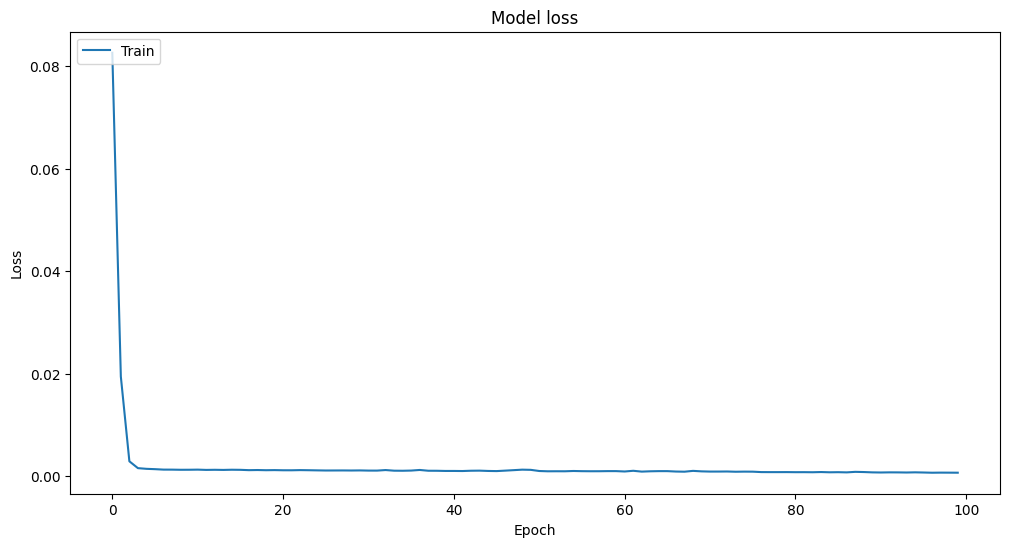

In [22]:
# Configure the neural network model
model = Sequential()

# Configure the Neural Network Model with n Neurons - inputshape = t Timestamps x f Features
n_neurons = X_train.shape[1] * x_train.shape[2]
print('timesteps: ' + str(x_train.shape[1]) + ',' + ' features:' + str(x_train.shape[2]))
# model.add(GRU(n_neurons, input_shape=(x_train.shape[1], x_train.shape[2]))) 
# model.add(Dense(1))
model.add(LSTM(n_neurons,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons,return_sequences=True))
model.add(LSTM(n_neurons))
model.add(Dense(1))


# Configure the Model   
optimizer='adam'; loss='mean_squared_error'; epochs = 100; batch_size = 64

# uncomment to customize the learning rate
learn_rate = "standard" # 0.05

parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'optimizer ' + str(optimizer) + ' with learn rate ' + str(learn_rate), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

# Compile and Training the model
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1)

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

(395, 7, 3) (199, 7, 3)
7/7 [==============================] - 0s 4ms/step


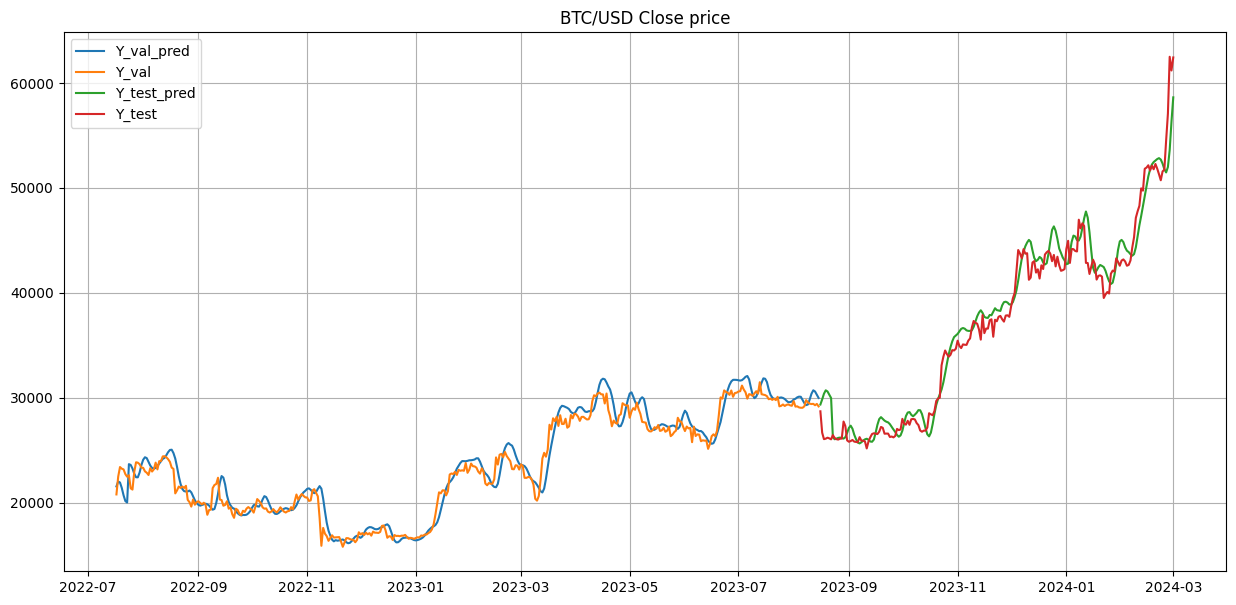

In [23]:
# Get x_val, x_test for the prediction from the last sequence_length days of the training set and the first sequence_length days of the validation set
x_val_pred = np.concatenate((x_train[-sequence_length:], x_val))
x_test_pred = np.concatenate((x_val[-sequence_length:], x_test))
print(x_val_pred.shape, x_test_pred.shape)
# Predict the values
y_val_pred = model.predict(x_val_pred)
y_test_pred = model.predict(x_test_pred)

# Inverse the scaling of the predicted values
y_val_pred_unscaled = scaler_pred.inverse_transform(y_val_pred)
y_test_pred_unscaled = scaler_pred.inverse_transform(y_test_pred)

# Create a dataframe for the validation set matching sliding window
day_val = pd.to_datetime(df_filtered.index[-val_size-test_size:-test_size])
df_val = pd.DataFrame(day_val, columns=['Date'])
df_val['Y_val_pred'] = y_val_pred_unscaled
df_val['Y_val'] = df_filtered['Close'][-val_size-test_size:-test_size].values
df_val.set_index('Date', inplace=True)

# Create a dataframe for the test set matching sliding window
day_test = pd.to_datetime(df_filtered.index[-test_size:])
df_test = pd.DataFrame(day_test, columns=['Date'])
df_test['Y_test_pred'] = y_test_pred_unscaled
df_test['Y_test'] = df_filtered['Close'][-test_size:].values
df_test.set_index('Date', inplace=True)


# # Plot df_val and df_test
plt.figure(figsize=(15, 7))
plt.plot(df_val['Y_val_pred'], label='Y_val_pred')
plt.plot(df_val['Y_val'], label='Y_val')
plt.plot(df_test['Y_test_pred'], label='Y_test_pred')
plt.plot(df_test['Y_test'], label='Y_test')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()


In [24]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904
...,...,...,...,...,...,...
2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,54522.402344,34074411896
2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,57085.371094,49756832031
2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,62504.789063,83239156760


1/1 [==============================] - 0s 22ms/step


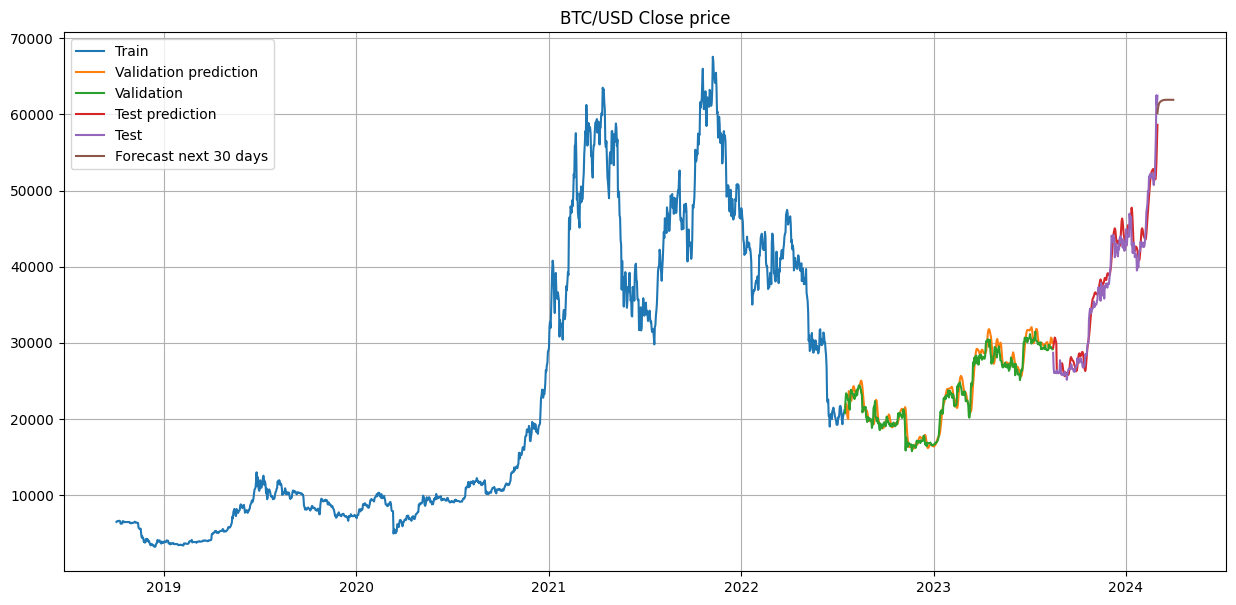

In [28]:
# forecast the next 30 days with index
def forecast(data, sequence_length, forecast_days):
    # Get the last sequence_length days
    x_forecast = data[-sequence_length:]
    y_forecast = []
    for i in range(forecast_days + 1):
        # Predict the next day
        y = model.predict(x_forecast.reshape(1, sequence_length, x_forecast.shape[1]))
        y_forecast.append(y[0][0])
        # Add the new prediction to the data
        x_forecast = np.insert(x_forecast, -1, y, axis=0)[1:]
    return y_forecast

# Forecast the next 30 days
forecast_days = 30
_forecast = forecast(np_data, sequence_length, forecast_days)
_forecast_unscaled = scaler_pred.inverse_transform(np.array(_forecast).reshape(-1, 1))

# Create the forecast dataframe
day_forecast = pd.date_range(start=day_test[-1], periods=forecast_days + 1)
df_forecast = pd.DataFrame(day_forecast, columns=['Date'])
df_forecast['Y_forecast'] = _forecast_unscaled
df_forecast.set_index('Date', inplace=True)
df_forecast

# Dateframe of Close training set
df_train = df_filtered['Close'][:train_size].copy()

# Plot the forecast for df_val, df_test and df_forecast
plt.figure(figsize=(15, 7))
plt.plot(df_train, label='Train')
plt.plot(df_val['Y_val_pred'], label='Validation prediction') 
plt.plot(df_val['Y_val'], label='Validation')
plt.plot(df_test['Y_test_pred'], label='Test prediction')
plt.plot(df_test['Y_test'], label='Test')
plt.plot(df_forecast['Y_forecast'], label='Forecast next 30 days')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()


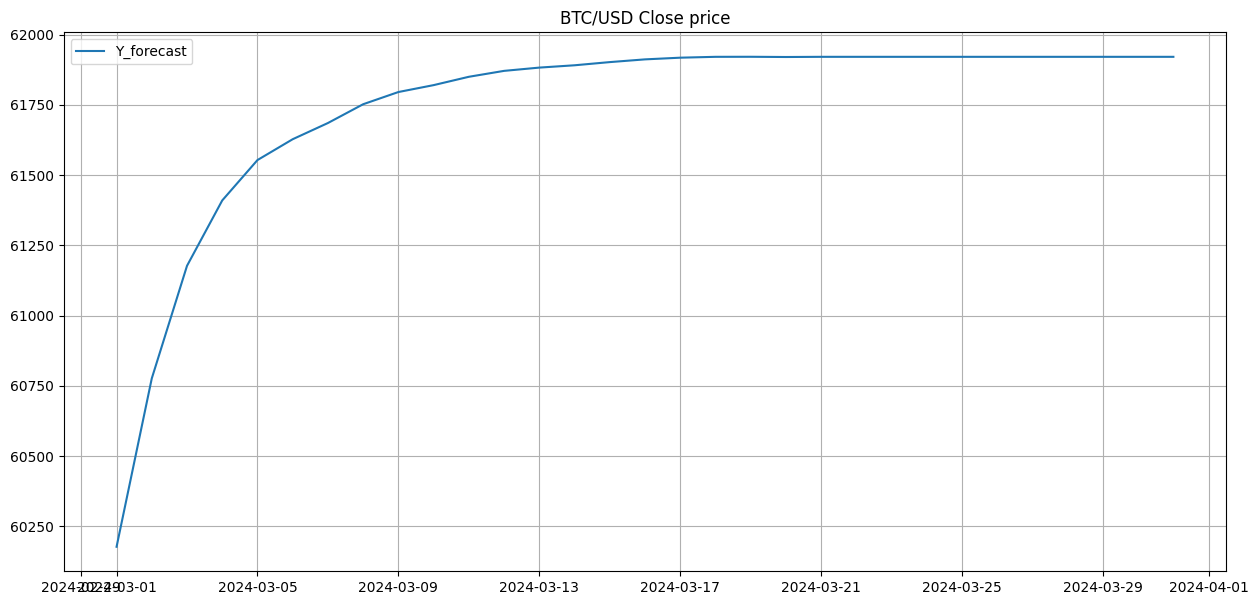

In [29]:
df_forecast.head(30)
# Plot df_forecast
plt.figure(figsize=(15, 7))
plt.plot(df_forecast)
plt.title('BTC/USD Close price')
plt.grid()
plt.legend(df_forecast.columns)
plt.show()

In [177]:
# Model Evaluation
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    mse = np.mean((y_true - y_pred)**2)
    return rmse, mape, smape, mse

# Calculate the metrics df_test
rmse, mape, smape, mse = calculate_metrics(df_test['Y_test'], df_test['Y_test_pred'])
print('Metrics for Test Data:')
print('RMSE: ', rmse)
print('MAPE: ', mape)
print('SMAPE: ', smape)
print('MSE: ', mse)

Metrics for Test Data:
RMSE:  1807.5598923574546
MAPE:  3.3834133050576245
SMAPE:  3.383339499647845
MSE:  3267272.764459293
